# Imports

In [1]:
!pip install sklearn --upgrade

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os 

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, RidgeClassifier, RidgeClassifierCV

# Loading data

In [61]:
employee = pd.read_csv('C:/py/data/attrition/employee_process.csv')

In [62]:
y=employee['y']
X=employee.drop(columns=['y'])

## Add non-linearities

In [63]:
augmentation =[ ]
for var in X.columns :
    if X[var].unique().tolist() == [0,1] :
        pass
    elif X[var].unique().tolist() ==[1,0]:
        pass
    else :
        augmentation.append(var)

In [64]:
for var in augmentation :
    
    X[var+'_squared'] = X[var]**2
    X[var+'_cube'] = X[var]**3

In [7]:
'''for i in range(len(augmentation)-1):
     X[augmentation[i]+'_'+augmentation[i+1]] = X[augmentation[i]]*X[augmentation[i+1]]'''

"for i in range(len(augmentation)-1):\n     X[augmentation[i]+'_'+augmentation[i+1]] = X[augmentation[i]]*X[augmentation[i+1]]"

### Split into train and test subsample

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [66]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1176, 95)
(1176,)
(294, 95)
(294,)


In [67]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [68]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Defition of the metrics function 

In [69]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score,accuracy_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

In [70]:
def recall_precision(y_test,y_pred,model):
    precision, recall, thresholds = precision_recall_curve(y_test,y_pred)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    fscore[np.isnan(fscore)] = 0
    #print(fscore)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    optimal_threshold = thresholds[ix]

    # plot the recall precision curve for the model
    plt.plot(recall, precision, marker='.', label=model)
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    # show the plot
    plt.show()
    
    print("\nTEST")
    print('Best Threshold=%f, F-Score=%.3f' % (optimal_threshold, fscore[ix]))
    y_pred2= np.where(y_pred <= optimal_threshold , 0, 1)
    cm = confusion_matrix(y_test, y_pred2)
    print("Confusion matrix \n" , cm)
    precision = cm[1,1]/sum(cm[:,1])
    print("\nPrecision : " + str(precision))
    recall = cm[1,1]/sum(cm[1,:])
    print("Recall : " + str(recall))
    f1 = 2*((precision*recall)/(precision+recall))
    print("F1 : " + str(f1))
    
    residual = (y_test - y_pred)
    print("\n Residuals distribution : \n", residual.describe())
    
    return optimal_threshold

# OLS

In [71]:
model = LinearRegression().fit(X_train, y_train)
y_ols = model.predict(X_test)

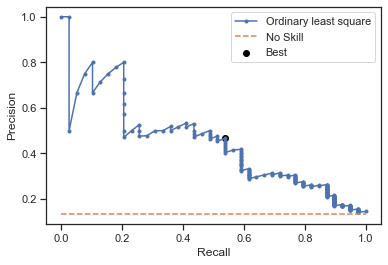


TEST
Best Threshold=0.415527, F-Score=0.500
Confusion matrix 
 [[231  24]
 [ 19  20]]

Precision : 0.45454545454545453
Recall : 0.5128205128205128
F1 : 0.48192771084337344

 Residuals distribution : 
 count    294.000000
mean      -0.030540
std        0.326804
min       -0.672363
25%       -0.232300
50%       -0.088013
75%        0.095276
max        1.133545
Name: y, dtype: float64


In [72]:
Tols = recall_precision(y_test,y_ols,'Ordinary least square')

In [73]:
y_ols2= np.where(y_ols <= Tols , 0, 1)

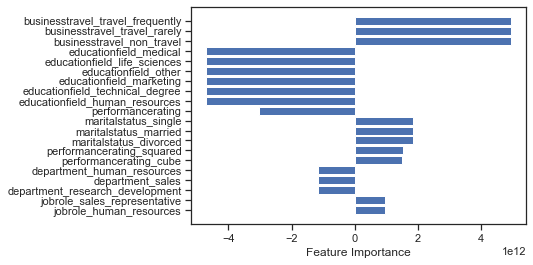

In [74]:
sort = abs(model.coef_).argsort()
sort = sort[-20:]
plt.barh(X.columns[sort], model.coef_[sort])
plt.xlabel("Feature Importance")
plt.show()

# Logistic regression

In [56]:
clf = LogisticRegression().fit(X_train, y_train)
y_log = clf.predict_proba(X_test)[:,1]

C:\Users\Bruguet\AppData\Local\Temp\ipykernel_105176\3661183176.py:4: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


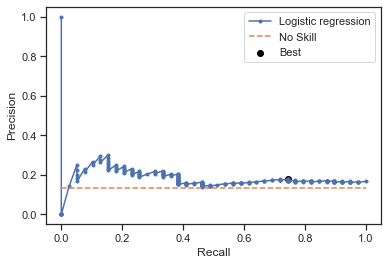


TEST
Best Threshold=0.213872, F-Score=0.287
Confusion matrix 
 [[121 134]
 [ 11  28]]

Precision : 0.1728395061728395
Recall : 0.717948717948718
F1 : 0.27860696517412936

 Residuals distribution : 
 count    294.000000
mean      -0.103579
std        0.347051
min       -0.496622
25%       -0.330483
50%       -0.189292
75%       -0.058170
max        0.899845
Name: y, dtype: float64


0.2138723808453251

In [57]:
recall_precision(y_test,y_log,'Logistic regression')

In [32]:
y_log2 = np.where(y_log <= 0.489009 , 0, 1)

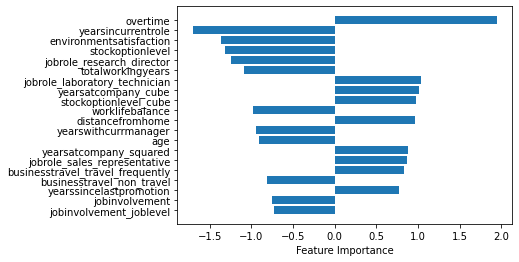

In [49]:
sort = abs(clf.coef_[0]).argsort()
sort = sort[-20:]
plt.barh(X.columns[sort], clf.coef_[0][sort])
plt.xlabel("Feature Importance")
plt.show()

# Ridge

In [75]:
alphas = 10**np.linspace(5,0,1000)*0.5

In [76]:
# Found the alpha
ridgecv = RidgeCV(alphas = alphas,
                  cv=10,
                  scoring = 'neg_mean_squared_error')
ridgecv.fit(X_train, y_train)
print("The optimal alpha seems to be :",round(ridgecv.alpha_,4))
# Train the model
Rclf = Ridge(alpha = ridgecv.alpha_)
trained_Rclf = Rclf.fit(X_train,y_train)
# Prediction
y_ridge = trained_Rclf.predict(X_test)

The optimal alpha seems to be : 0.5


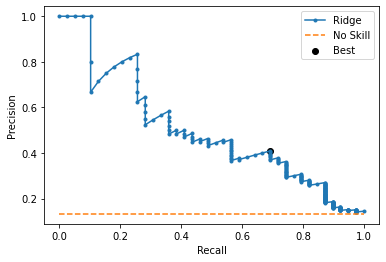


TEST
Best Threshold=0.316277, F-Score=0.514
Confusion matrix 
 [[216  39]
 [ 13  26]]

Precision : 0.4
Recall : 0.6666666666666666
F1 : 0.5

 Residuals distribution : 
 count    294.000000
mean      -0.026969
std        0.318919
min       -0.582611
25%       -0.221370
50%       -0.103232
75%        0.089708
max        1.111880
Name: y, dtype: float64


In [20]:
Tridge = recall_precision(y_test,y_ridge,'Ridge')

In [77]:
y_ridge2 = np.where(y_ridge <= Tridge , 0, 1)

In [80]:
print('The automatic selection method Ridge selected', sum(trained_Rclf.coef_ > 0.001), 'variables in a pool of 95.')

The automatic selection method Ridge selected 48 variables in a pool of 95.


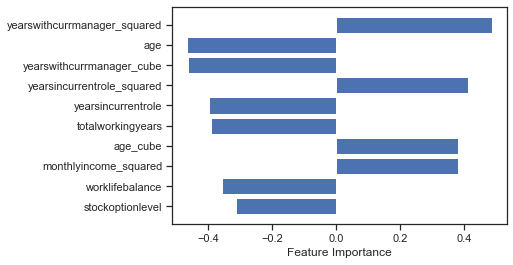

In [81]:
sort = abs(Rclf.coef_).argsort()
sort = sort[-10:]
plt.barh(X.columns[sort], Rclf.coef_[sort])
plt.xlabel("Feature Importance")
plt.show()

In [82]:
sort_ = abs(Rclf.coef_).argsort()
sort_ = sort_[-48:]
selection = pd.DataFrame({
    'Variables' : X.columns[sort_],
    'Coefficient' : Rclf.coef_[sort_]

})
selection['trie'] = abs(selection['Coefficient'])
selection = selection.sort_values(by=['trie'],ascending=False)
selection = selection.drop(columns=['trie'])

var_ridge = selection['Variables']
selection

,Variables,Coefficient
47,yearswithcurrmanager_squared,0.485312
46,age,-0.465358
45,yearswithcurrmanager_cube,-0.463882
44,yearsincurrentrole_squared,0.412798
43,yearsincurrentrole,-0.398133
42,totalworkingyears,-0.390634
41,age_cube,0.381910
40,monthlyincome_squared,0.381858
39,worklifebalance,-0.356324
38,stockoptionlevel,-0.313829


In [83]:
#lassocv = LassoCV(alphas = alphas,cv= 10)
lassocv = LassoCV(alphas = None,
                  cv = 10, 
                  random_state = 0,
                  max_iter = 10000)
lassocv.fit(X_train, y_train)
# Optimal alpha
print("The optimal alpha seems to be : ", round(lassocv.alpha_,4))

C:\Users\Bruguet\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015151125710929136, tolerance: 0.014805293005671075
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Bruguet\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014833169636347066, tolerance: 0.014805293005671075
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Bruguet\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01486810408678707, tolerance: 0.014541076487252128
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Bruguet\anaconda3\lib\site-packages\sklearn\linear_model\_coor

The optimal alpha seems to be :  0.0001


In [84]:
lasso = Lasso(max_iter = 100000)
# Train the model
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
# Prediction
y_lasso = lasso.predict(X_test)

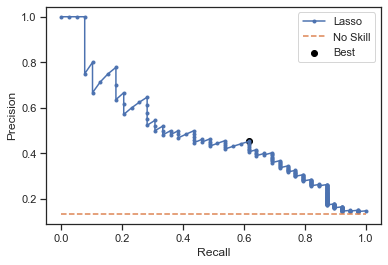


TEST
Best Threshold=0.354210, F-Score=0.522
Confusion matrix 
 [[226  29]
 [ 16  23]]

Precision : 0.4423076923076923
Recall : 0.5897435897435898
F1 : 0.5054945054945056

 Residuals distribution : 
 count    294.000000
mean      -0.026742
std        0.319476
min       -0.623593
25%       -0.219958
50%       -0.085323
75%        0.076116
max        1.085029
Name: y, dtype: float64


In [85]:
Tlasso = recall_precision(y_test,y_lasso,'Lasso')

In [86]:
y_lasso2 = np.where(y_lasso <= Tlasso , 0, 1)

In [87]:
print('The automatic selection method lasso selected', sum(lasso.coef_ > 0.001), 'variables in a pool of 117.')

The automatic selection method lasso selected 35 variables in a pool of 117.


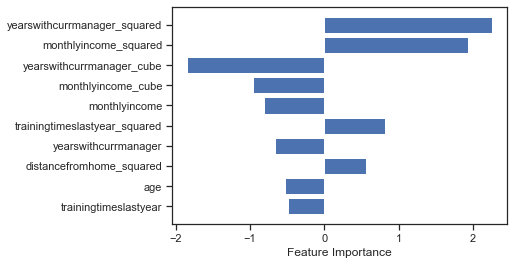

In [88]:
sort = abs(lasso.coef_).argsort()
sort = sort[-10:]
plt.barh(X.columns[sort], lasso.coef_[sort])
plt.xlabel("Feature Importance")
plt.show()

In [89]:
sort_ = abs(lasso.coef_).argsort()
sort_ = sort_[-35:]
selection = pd.DataFrame({
    'Variables' : X.columns[sort_],
    'Coefficient' : lasso.coef_[sort_]
})

selection['trie'] = abs(selection['Coefficient'])
selection = selection.sort_values(by=['trie'],ascending=False)
selection = selection.drop(columns=['trie'])
var_lasso = selection['Variables']
selection

,Variables,Coefficient
34,yearswithcurrmanager_squared,2.246730
33,monthlyincome_squared,1.925869
32,yearswithcurrmanager_cube,-1.846690
31,monthlyincome_cube,-0.961196
30,monthlyincome,-0.817026
29,trainingtimeslastyear_squared,0.807918
28,yearswithcurrmanager,-0.661530
27,distancefromhome_squared,0.561024
26,age,-0.533108
25,trainingtimeslastyear,-0.487658


In [35]:
import statsmodels.api as sm

C:\Users\Bruguet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Bruguet\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [44]:
X_ols = X[var_lasso]
X_ols = sm.add_constant(X_ols)

C:\Users\Bruguet\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [45]:
model = sm.OLS(y,X_ols)
results = model.fit()

In [46]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     14.55
Date:                Wed, 13 Apr 2022   Prob (F-statistic):           1.12e-71
Time:                        09:53:50   Log-Likelihood:                -391.85
No. Observations:                1470   AIC:                             855.7
Df Residuals:                    1434   BIC:                             1046.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             1.8786      0.193      9.746      0.000       1.500       2.257
yearswithcurrmanager_squared      0.0089      0.003      3.538      0.000       0.004       0.014
monthlyincome_squared          5.804e-09   2.71e-09      2.143      0.032    4.92e-10    1.11e-08
yearswithcurrmanager_cube        -0.0004      0.000     -3.640      0.000      -0.001      -0.000
monthlyincome_cube            -2.091e-13   8.64e-14     -2.419      0.016   -3.79e-13   -3.95e-14
monthlyincome                 -5.126e-05   2.64e-05     -1.941      0.052      -0.000    5.38e-07
trainingtimeslastyear_squared     0.0406      0.018      2.229      0.026       0.005       0.076
yearswithcurrmanager             -0.0480      0.015     -3.213      0.001      -0.077      -0.019
distancefromhome_squared          0.0005      0.000      2.317      0.021    7.84e-05       0.001
age                              -0.0145      0.004     -3.761      0.000      -0.022      -0.007
trainingtimeslastyear            -0.1213      0.048     -2.542      0.011      -0.215      -0.028
age_cube                       2.384e-06   7.65e-07      3.117      0.002    8.83e-07    3.88e-06
yearsatcompany_cube             4.29e-06    2.3e-06      1.867      0.062   -2.18e-07     8.8e-06
distancefromhome_cube         -1.444e-05   8.34e-06     -1.731      0.084   -3.08e-05    1.92e-06
trainingtimeslastyear_cube       -0.0042      0.002     -2.096      0.036      -0.008      -0.000
worklifebalance                  -0.1489      0.034     -4.403      0.000      -0.215      -0.083
yearsincurrentrole_squared        0.0003      0.001      0.588      0.557      -0.001       0.001
yearsincurrentrole               -0.0101      0.008     -1.257      0.209      -0.026       0.006
stockoptionlevel                 -0.1641      0.026     -6.399      0.000      -0.214      -0.114
jobinvolvement                   -0.1493      0.061     -2.443      0.015      -0.269      -0.029
totalworkingyears                -0.0066      0.002     -2.771      0.006      -0.011      -0.002
stockoptionlevel_squared          0.0479      0.010      4.888      0.000       0.029       0.067
worklifebalance_cube              0.0057      0.001      3.845      0.000       0.003       0.009
environmentsatisfaction          -0.0397      0.008     -5.131      0.000      -0.055      -0.025
joblevel                         -0.1123      0.067     -1.665      0.096      -0.245       0.020
jobsatisfaction                  -0.0550      0.044     -1.257      0.209      -0.141       0.031
percentsalaryhike_cube          1.73e-05   1.21e-05      1.430      0.153   -6.43e-06     4.1e-05
overtime                          0.1993      0.019     10.581      0.000       0.162       0.236
joblevel_squared                  0.0278     

# Model comparaisons

## Residuals analysis

C:\Users\Bruguet\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Bruguet\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Bruguet\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

Text(0.5, 1.0, 'Residuals distribution')

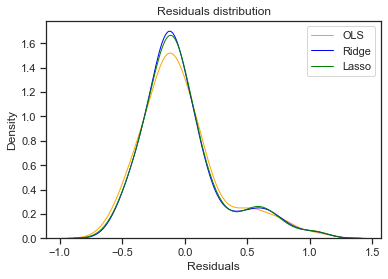

In [36]:
sns.set(style="ticks", color_codes=True)
sns.distplot((y_test-y_ols), hist=False, kde=True, kde_kws = {'shade': False, 'linewidth' : 1},
             bins=50, color = 'orange',
             hist_kws={'edgecolor':'black'})
sns.distplot((y_test-y_ridge), hist=False, kde=True, kde_kws = {'shade': False, 'linewidth' : 1},
             bins=50, color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot((y_test-y_lasso), hist=False, kde=True, kde_kws = {'shade': False, 'linewidth' : 1},
             bins=50, color = 'green',
             hist_kws={'edgecolor':'black'})
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend(labels=["OLS","Ridge", "Lasso"])
plt.title('Residuals distribution')

### Using PrecisionRecallDisplay.**from_estimators**

In [40]:
def recall (y_test,y_pred,model) :
    
    precision, recall, thresholds = precision_recall_curve(y_test,y_pred)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    # plot the roc curve for the model
    recall_plot = plt.plot(recall, precision, marker='.', label=model)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    # show the plot
    return(recall_plot)

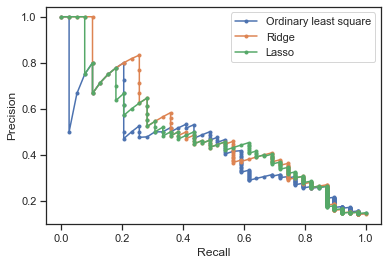

In [41]:
recall_ols = recall(y_test,y_ols, 'Ordinary least square')
recall_rige = recall(y_test,y_ridge, 'Ridge')
recall_lasso = recall(y_test,y_lasso,'Lasso')

In [42]:
 f_score = pd.DataFrame({
    'Algorithm' : ['OLS','Ridge','Lasso'],
    'y_pred' : [y_ols2,y_ridge2,y_lasso2]
})
f1_list = []
for index, row in f_score.iterrows():
    f1 = f1_score(y_test, row['y_pred'], average='binary')
    f1_list.append(f1)
acc_list = []
for index, row in f_score.iterrows():
    acc = accuracy_score(y_test, row['y_pred'])
    acc_list.append(acc)
    
f_score['f1']=f1_list
f_score['acc']=acc_list
f_score = f_score.drop(['y_pred'], axis=1)
f_score.sort_values(by=['f1'],ascending=False)

,Algorithm,f1,acc
2,Lasso,0.505495,0.846939
1,Ridge,0.500000,0.823129
0,OLS,0.481928,0.853741
